# Regime Detection Strategy and Evaluation Notebook

This notebook demonstrates:
1. Market regime detection using Hidden Markov Models (HMM)
2. Strategy backtesting with multiple approaches
3. Performance evaluation and comparison
4. Risk-adjusted returns analysis

In [36]:
# Import required libraries
import sys
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add src directory to path
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))

# Import custom modules
from regime_detction import RegimeDetector
from strategy_backtest import StrategyBacktest

warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 8)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [ ]:
# Define data paths
data_path = Path('data/processed')
results_path = Path('results/strategy_eval')

# Create results directory if it doesn't exist
results_path.mkdir(parents=True, exist_ok=True)

print(f"Data path: {data_path}")
print(f"Results path: {results_path}")

Data path: data\processed
Results path: results\plots\strategy_eval


## 1. Load Data

Load processed data for analysis.

In [38]:
# Load equity data
equity_files = list(data_path.glob('Equity_*.csv'))
print(f"Found {len(equity_files)} equity files")

# Load a sample equity for analysis (Apple)
apple_file = [f for f in equity_files if 'AAPL' in f.name]
if apple_file:
    aapl_df = pd.read_csv(apple_file[0], index_col=0, parse_dates=True)
    print(f"\n✓ Loaded Apple data: {aapl_df.shape}")
    print(f"Date range: {aapl_df.index[0]} to {aapl_df.index[-1]}")
    print(f"Columns: {list(aapl_df.columns)}")
else:
    print("Apple data not found")

Found 8 equity files

✓ Loaded Apple data: (2515, 5)
Date range: 2015-01-02 00:00:00 to 2024-12-30 00:00:00
Columns: ['Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL']


## 2. Regime Detection with HMM

Apply Hidden Markov Models to detect market regimes.

In [39]:
# Initialize regime detector with 3 regimes
detector = RegimeDetector(n_regimes=3, n_iter=100, random_state=42)

# Prepare features for regime detection
features = detector.prepare_features(aapl_df)

print(f"✓ Features prepared: {features.shape}")
print(f"\nFeature columns: {list(features.columns)}")
print(f"\nFeature summary:\n{features.describe()}")

✓ Features prepared: (2466, 6)

Feature columns: ['returns', 'volatility', 'volume_change', 'momentum_5', 'momentum_21', 'ma_ratio']

Feature summary:
           returns   volatility  volume_change   momentum_5  momentum_21  \
count  2466.000000  2466.000000    2466.000000  2466.000000  2466.000000   
mean      0.001058     0.016284       0.049190     0.005210     0.021786   
std       0.017929     0.007612       0.354375     0.037380     0.079986   
min      -0.128647     0.004904      -0.830093    -0.175307    -0.284296   
25%      -0.007328     0.011427      -0.173945    -0.016192    -0.027990   
50%       0.000942     0.014648      -0.016762     0.006579     0.023553   
75%       0.010134     0.019285       0.194151     0.027090     0.077396   
max       0.119808     0.067185       3.771993     0.184141     0.361382   

          ma_ratio  
count  2466.000000  
mean      0.013325  
std       0.043043  
min      -0.121577  
25%      -0.012869  
50%       0.014174  
75%       0.04368

In [40]:
# Fit HMM and predict regimes
regimes, regime_probs = detector.fit_predict(features)

print(f"✓ Regimes detected: {len(np.unique(regimes))} unique regimes")
print(f"\nRegime distribution:")
for regime in range(detector.n_regimes):
    count = np.sum(regimes == regime)
    percentage = count / len(regimes) * 100
    print(f"  Regime {regime}: {count} days ({percentage:.1f}%)")

✓ Regimes detected: 3 unique regimes

Regime distribution:
  Regime 0: 921 days (37.3%)
  Regime 1: 954 days (38.7%)
  Regime 2: 591 days (24.0%)


In [41]:
# Display regime statistics
regime_stats = detector.get_regime_statistics(features, regimes)
print("\nRegime Statistics:")
print("=" * 80)
print(regime_stats.to_string(index=False))
print("\n" + "=" * 80)


Regime Statistics:
 Regime  Count  Percentage  Mean_Return  Std_Return  Mean_Volatility
      0    921   37.347932     0.000925    0.015921         0.015901
      1    954   38.686131     0.001709    0.010860         0.010538
      2    591   23.965937     0.000214    0.027492         0.026157



In [42]:
# Display transition probability matrix
trans_matrix = detector.get_transition_matrix()
print("\nTransition Probability Matrix:")
print("=" * 80)
print(trans_matrix.round(4))
print("\n" + "=" * 80)


Transition Probability Matrix:
               To Regime 0  To Regime 1  To Regime 2
From Regime 0        0.952       0.0292       0.0188
From Regime 1        0.027       0.9730       0.0000
From Regime 2        0.029       0.0000       0.9710



### Visualize Regimes

✓ Plot saved to results\plots\strategy_eval\regime_overlay_aapl.png


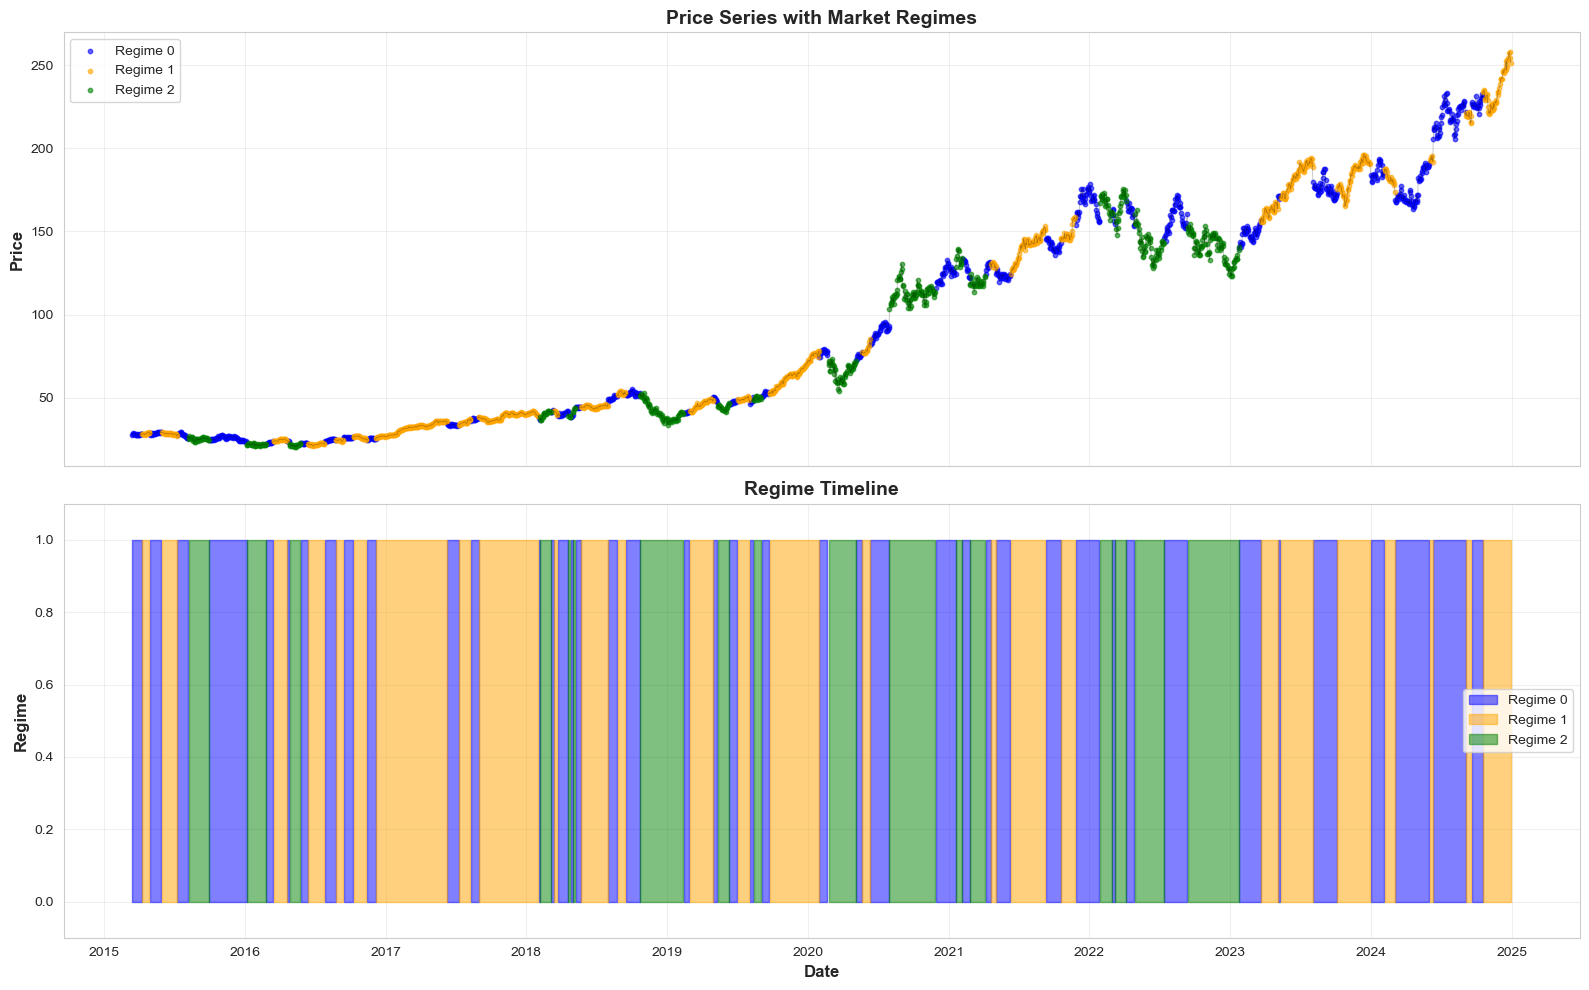

In [43]:
# Plot price series with regime overlay
detector.plot_regimes(
    aapl_df, 
    features, 
    regimes,
    save_path=results_path / 'regime_overlay_aapl.png'
)

✓ Plot saved to results\plots\strategy_eval\regime_characteristics_aapl.png


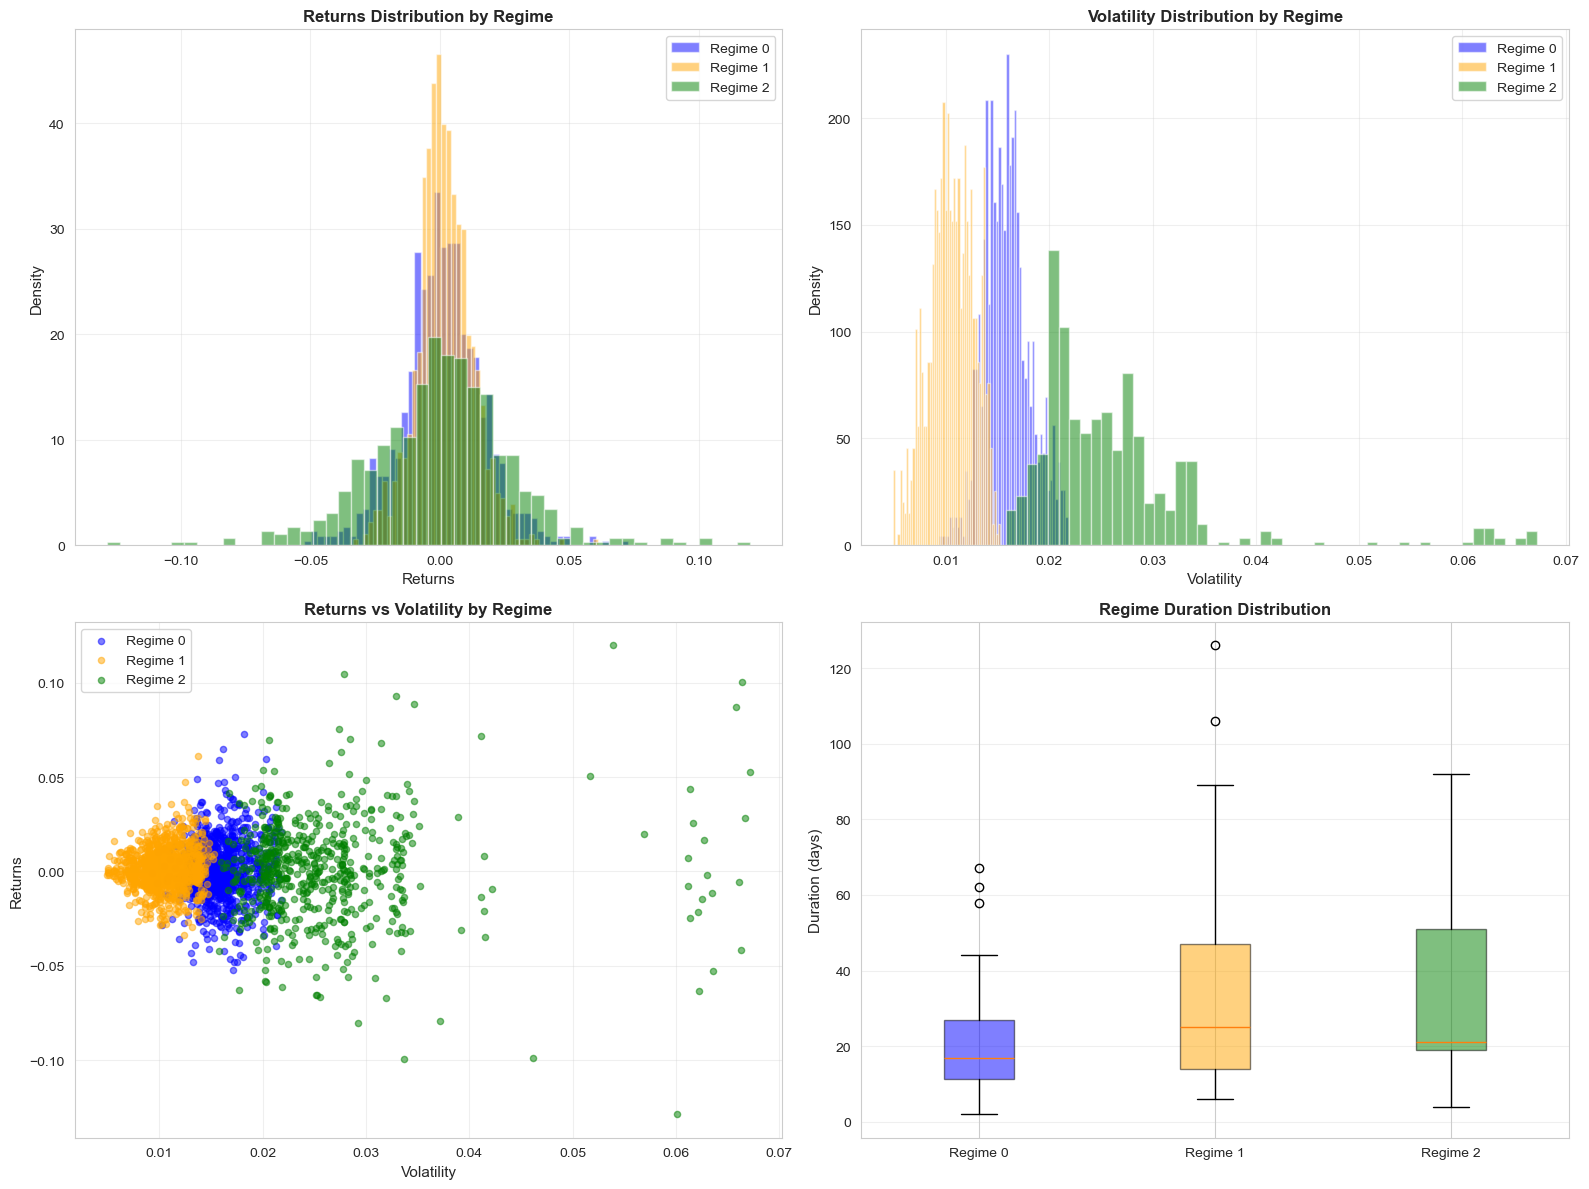

In [44]:
# Plot regime characteristics
detector.plot_regime_characteristics(
    features,
    regimes,
    save_path=results_path / 'regime_characteristics_aapl.png'
)

## 3. Strategy Backtesting

Test multiple trading strategies on the data.

In [45]:
# Initialize backtester
backtester = StrategyBacktest(initial_capital=100000, commission=0.001)

print("✓ Backtester initialized")
print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
print(f"Commission Rate: {backtester.commission:.2%}")

✓ Backtester initialized
Initial Capital: $100,000.00
Commission Rate: 0.10%


### 3.1 Moving Average Strategy

In [46]:
# Generate signals for moving average strategy
ma_signals = backtester.generate_signals(aapl_df, strategy='moving_average', 
                                          short_window=20, long_window=50)

print(f"✓ Generated {len(ma_signals)} trading signals")
print(f"\nSignal distribution:")
print(ma_signals['signal'].value_counts())

✓ Generated 2466 trading signals

Signal distribution:
signal
 1    1580
-1     886
Name: count, dtype: int64


In [47]:
# Run backtest for moving average strategy
ma_portfolio = backtester.run_backtest(aapl_df, ma_signals)

print(f"✓ Backtest completed")
print(f"Total trades: {len(backtester.trades)}")
print(f"\nPortfolio summary:")
print(f"  Initial value: ${backtester.initial_capital:,.2f}")
print(f"  Final value: ${ma_portfolio['total'].iloc[-1]:,.2f}")
print(f"  Total return: {ma_portfolio['cumulative_returns'].iloc[-1]:.2%}")

✓ Backtest completed
Total trades: 56

Portfolio summary:
  Initial value: $100,000.00
  Final value: $100,056.80
  Total return: 0.03%


In [48]:
# Calculate performance metrics
ma_metrics = backtester.calculate_metrics(ma_portfolio)

print("\nMoving Average Strategy Performance:")
print("=" * 80)
for metric, value in ma_metrics.items():
    if isinstance(value, float):
        if 'Ratio' in metric or 'Return' in metric or 'Volatility' in metric or 'Drawdown' in metric or 'Rate' in metric:
            print(f"{metric:.<30} {value:.4f}")
        else:
            print(f"{metric:.<30} ${value:,.2f}")
    else:
        print(f"{metric:.<30} {value}")
print("=" * 80)


Moving Average Strategy Performance:
Total Return.................. 0.0003
Annual Return................. 0.0000
Annual Volatility............. 0.0003
Sharpe Ratio.................. 0.0962
Sortino Ratio................. 0.1226
Max Drawdown.................. -0.0010
Calmar Ratio.................. 0.0308
Win Rate...................... 0.5000
Total Trades.................. 56
Final Value................... $100,056.80


✓ Plot saved to results\plots\strategy_eval\ma_strategy_performance.png


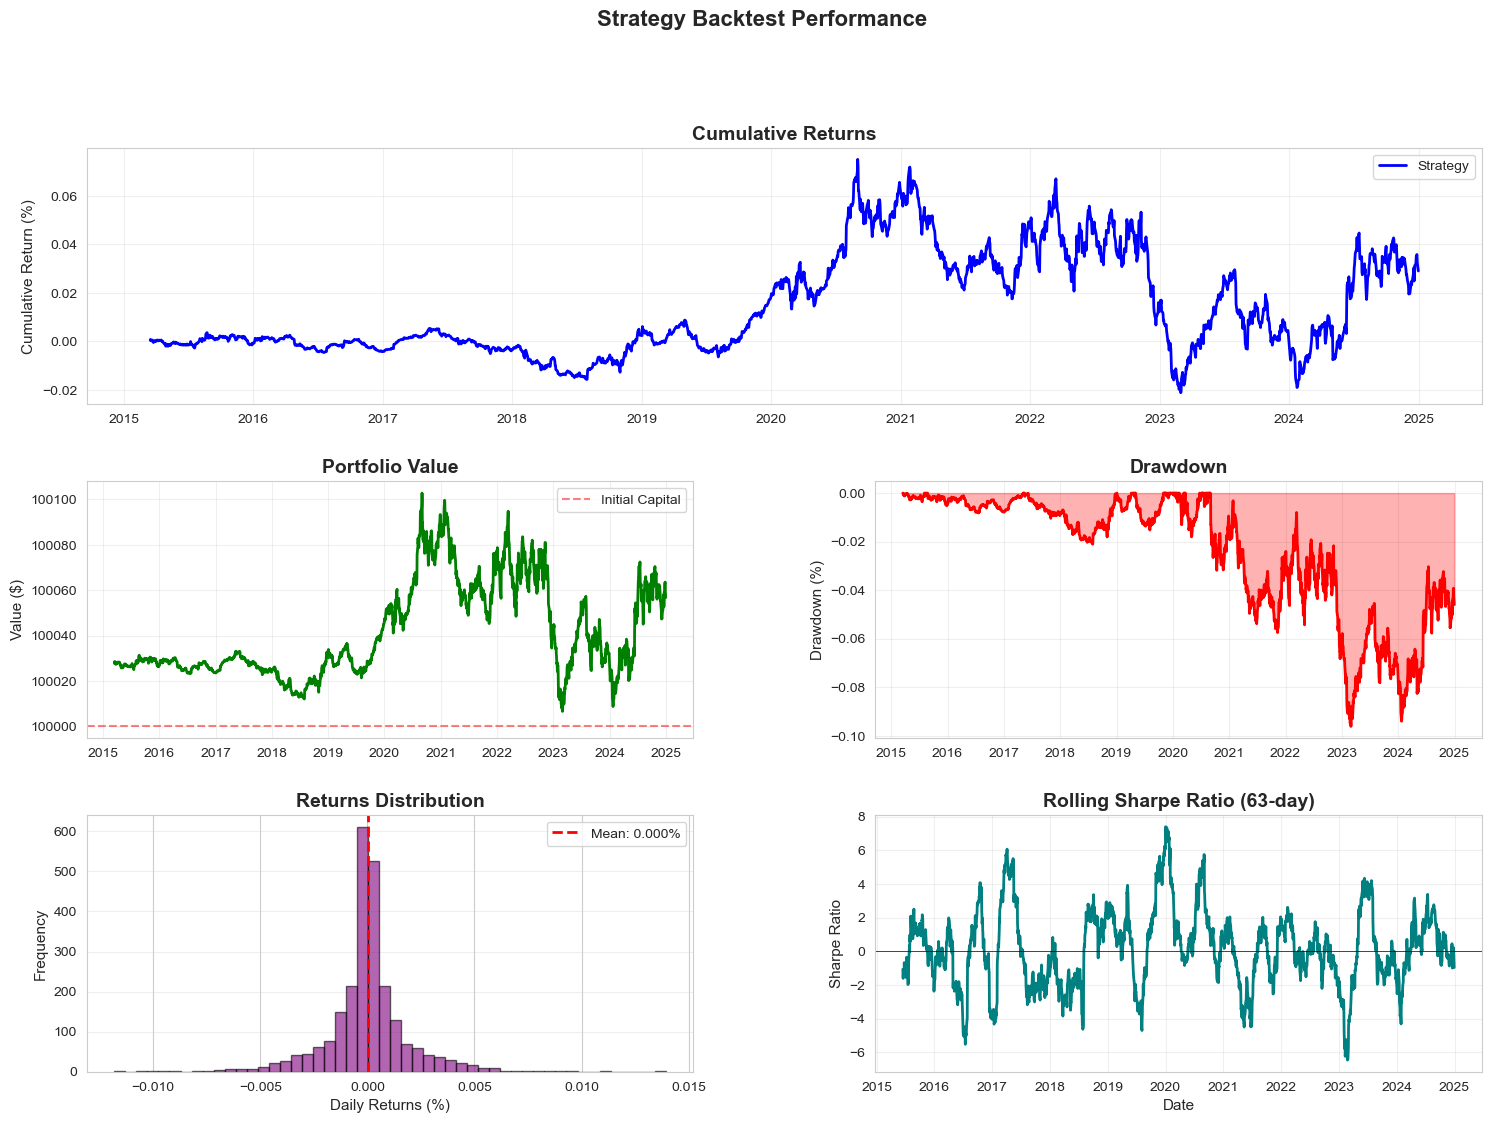

In [49]:
# Plot moving average strategy performance
backtester.plot_performance(
    ma_portfolio,
    save_path=results_path / 'ma_strategy_performance.png'
)

✓ Plot saved to results\plots\strategy_eval\ma_strategy_trades.png


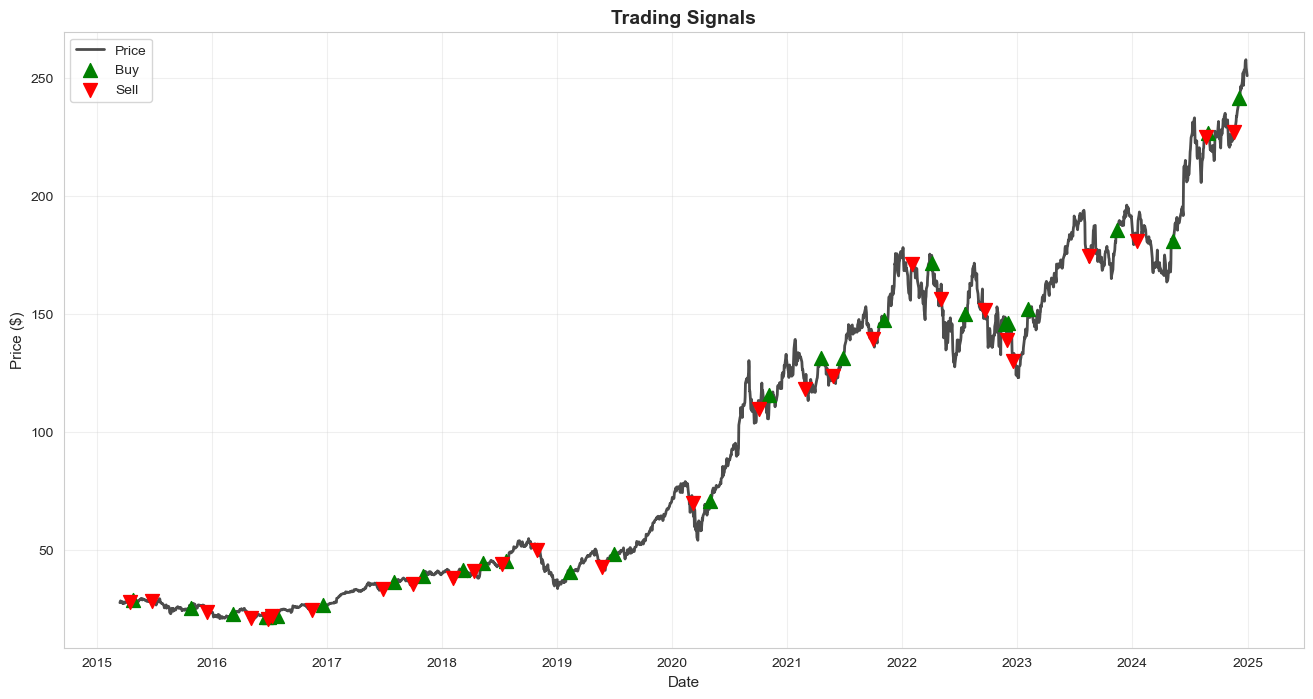

In [50]:
# Plot trading signals
backtester.plot_trades(
    ma_portfolio,
    save_path=results_path / 'ma_strategy_trades.png'
)

### 3.2 Compare Multiple Strategies

✓ Plot saved to results\plots\strategy_eval\strategy_comparison.png


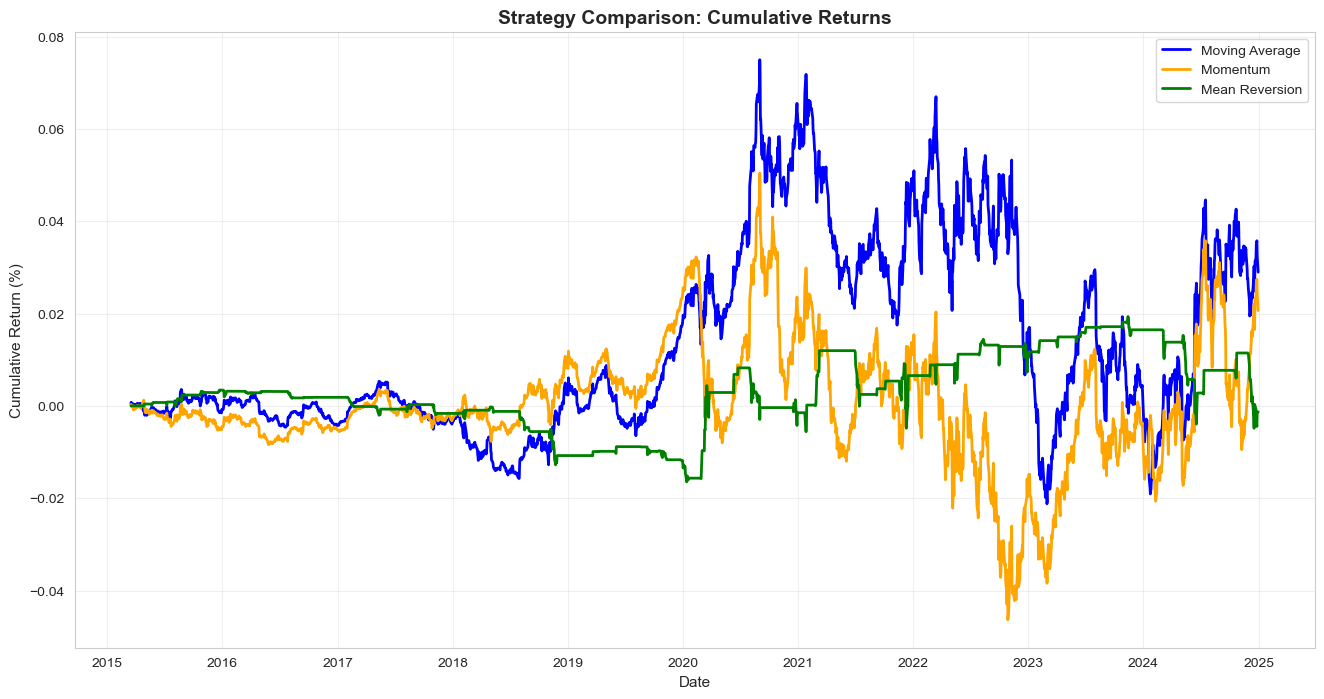


Strategy Comparison:
                Total Return  Annual Return  Annual Volatility  Sharpe Ratio  \
Strategy                                                                       
moving_average        0.0003            0.0             0.0003        0.0962   
momentum              0.0002            0.0             0.0003        0.0681   
mean_reversion       -0.0000           -0.0             0.0001       -0.0120   

                Sortino Ratio  Max Drawdown  Calmar Ratio  Win Rate  \
Strategy                                                              
moving_average         0.1226       -0.0010        0.0308    0.5000   
momentum               0.0843       -0.0010        0.0218    0.5000   
mean_reversion        -0.0073       -0.0002       -0.0055    0.1714   

                Total Trades  Final Value  
Strategy                                   
moving_average            56  100056.8023  
momentum                 128  100048.9209  
mean_reversion           210   99998.7029  


In [51]:
# Compare all three strategies
strategies = ['moving_average', 'momentum', 'mean_reversion']

comparison_df = backtester.compare_strategies(
    aapl_df,
    strategies,
    save_path=results_path / 'strategy_comparison.png'
)

print("\nStrategy Comparison:")
print("=" * 80)
print(comparison_df.round(4))
print("=" * 80)

### 3.3 Strategy Performance Heatmap

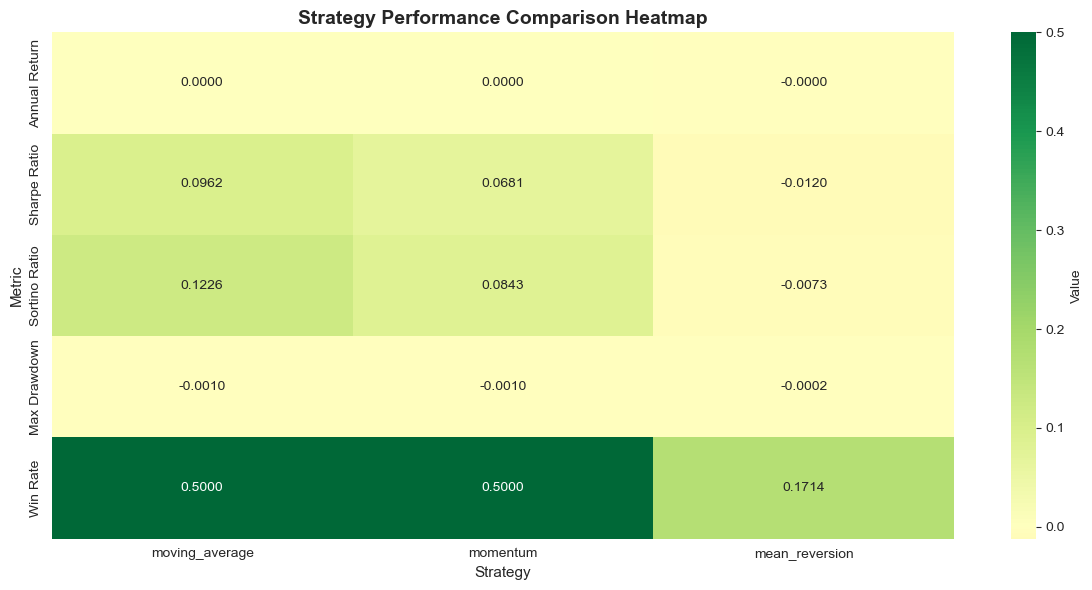

✓ Heatmap saved


In [52]:
# Create heatmap of key metrics
metrics_for_heatmap = ['Annual Return', 'Sharpe Ratio', 'Sortino Ratio', 
                       'Max Drawdown', 'Win Rate']

heatmap_data = comparison_df[metrics_for_heatmap].T

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='RdYlGn', 
            center=0, cbar_kws={'label': 'Value'})
plt.title('Strategy Performance Comparison Heatmap', fontsize=14, fontweight='bold')
plt.xlabel('Strategy', fontsize=11)
plt.ylabel('Metric', fontsize=11)
plt.tight_layout()
plt.savefig(results_path / 'strategy_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Heatmap saved")

## 4. Regime-Based Analysis

Analyze strategy performance across different market regimes.

In [53]:
# Align regime data with portfolio returns
ma_portfolio_aligned = ma_portfolio.loc[features.index]
ma_portfolio_aligned['regime'] = regimes

# Calculate returns by regime
regime_performance = []

for regime in range(detector.n_regimes):
    regime_mask = ma_portfolio_aligned['regime'] == regime
    regime_returns = ma_portfolio_aligned.loc[regime_mask, 'returns']
    
    regime_performance.append({
        'Regime': regime,
        'Observations': regime_mask.sum(),
        'Mean Return': regime_returns.mean(),
        'Std Return': regime_returns.std(),
        'Sharpe (daily)': regime_returns.mean() / regime_returns.std() if regime_returns.std() > 0 else 0,
        'Win Rate': (regime_returns > 0).sum() / len(regime_returns) if len(regime_returns) > 0 else 0
    })

regime_perf_df = pd.DataFrame(regime_performance)

print("\nStrategy Performance by Regime:")
print("=" * 80)
print(regime_perf_df.to_string(index=False))
print("=" * 80)


Strategy Performance by Regime:
 Regime  Observations   Mean Return  Std Return  Sharpe (daily)  Win Rate
      0           921 -1.073690e-07    0.000020       -0.005261  0.499457
      1           954  7.234544e-07    0.000012        0.061291  0.514675
      2           591 -5.095236e-07    0.000026       -0.019277  0.468697


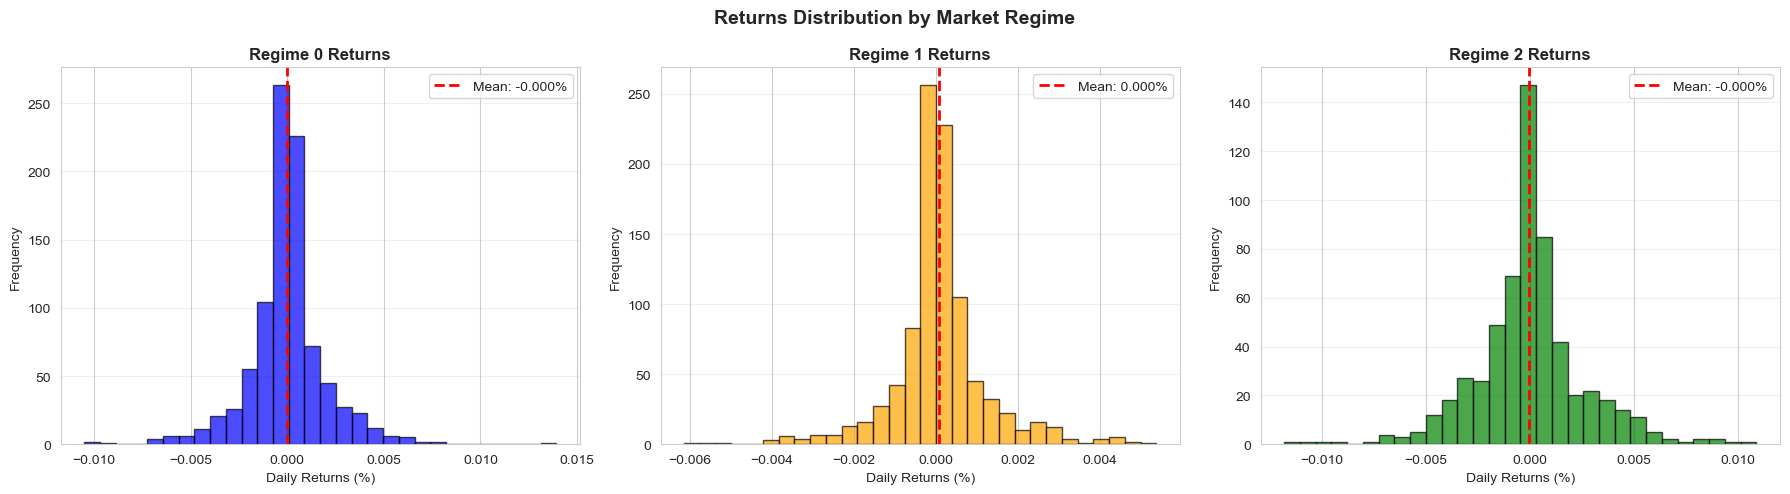

✓ Plot saved


In [54]:
# Visualize returns by regime
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['blue', 'orange', 'green']

for regime in range(detector.n_regimes):
    regime_mask = ma_portfolio_aligned['regime'] == regime
    regime_returns = ma_portfolio_aligned.loc[regime_mask, 'returns'] * 100
    
    axes[regime].hist(regime_returns, bins=30, color=colors[regime], alpha=0.7, edgecolor='black')
    axes[regime].axvline(x=regime_returns.mean(), color='red', linestyle='--', 
                        linewidth=2, label=f'Mean: {regime_returns.mean():.3f}%')
    axes[regime].set_title(f'Regime {regime} Returns', fontsize=12, fontweight='bold')
    axes[regime].set_xlabel('Daily Returns (%)', fontsize=10)
    axes[regime].set_ylabel('Frequency', fontsize=10)
    axes[regime].legend()
    axes[regime].grid(True, alpha=0.3, axis='y')

plt.suptitle('Returns Distribution by Market Regime', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(results_path / 'returns_by_regime.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved")

## 5. Multi-Asset Analysis

Apply regime detection and strategy evaluation to multiple assets.

In [55]:
# Select a few equities for comparison
equity_tickers = ['AAPL', 'MSFT', 'GOOGL']
multi_asset_results = []

for ticker in equity_tickers:
    # Load data
    ticker_file = [f for f in equity_files if ticker in f.name]
    if not ticker_file:
        continue
    
    df = pd.read_csv(ticker_file[0], index_col=0, parse_dates=True)
    
    # Initialize backtester
    bt = StrategyBacktest(initial_capital=100000, commission=0.001)
    
    # Run moving average strategy
    signals = bt.generate_signals(df, strategy='moving_average')
    portfolio = bt.run_backtest(df, signals)
    metrics = bt.calculate_metrics(portfolio)
    
    # Store results
    result = {
        'Ticker': ticker,
        'Final Value': metrics['Final Value'],
        'Total Return': metrics['Total Return'],
        'Annual Return': metrics['Annual Return'],
        'Sharpe Ratio': metrics['Sharpe Ratio'],
        'Max Drawdown': metrics['Max Drawdown'],
        'Total Trades': metrics['Total Trades']
    }
    multi_asset_results.append(result)
    
    print(f"✓ Processed {ticker}")

multi_asset_df = pd.DataFrame(multi_asset_results)

print("\n\nMulti-Asset Strategy Performance:")
print("=" * 80)
print(multi_asset_df.to_string(index=False))
print("=" * 80)

✓ Processed AAPL
✓ Processed MSFT
✓ Processed MSFT
✓ Processed GOOGL


Multi-Asset Strategy Performance:
Ticker   Final Value  Total Return  Annual Return  Sharpe Ratio  Max Drawdown  Total Trades
  AAPL 100056.802294      0.000290       0.000030      0.096154     -0.000961            56
  MSFT  99814.176957     -0.001501      -0.000154     -0.273438     -0.002430            53
 GOOGL 100032.283939      0.000044       0.000004      0.016403     -0.000890            54
✓ Processed GOOGL


Multi-Asset Strategy Performance:
Ticker   Final Value  Total Return  Annual Return  Sharpe Ratio  Max Drawdown  Total Trades
  AAPL 100056.802294      0.000290       0.000030      0.096154     -0.000961            56
  MSFT  99814.176957     -0.001501      -0.000154     -0.273438     -0.002430            53
 GOOGL 100032.283939      0.000044       0.000004      0.016403     -0.000890            54


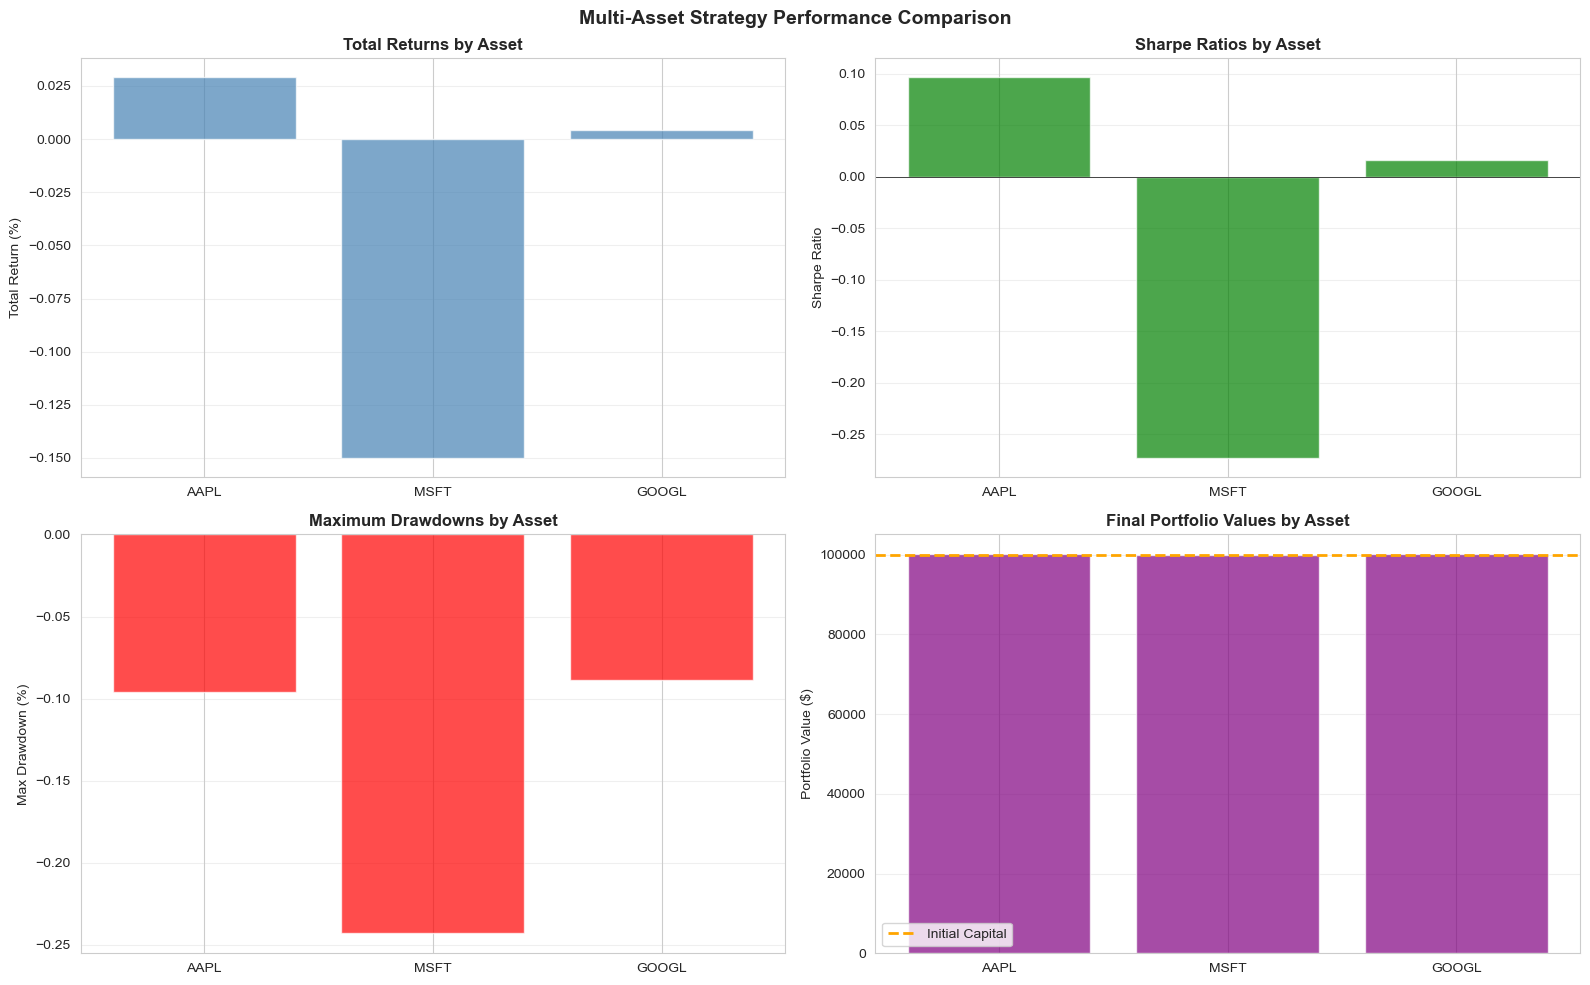

✓ Multi-asset visualization saved


In [56]:
# Visualize multi-asset performance
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

# Plot 1: Total Returns
axes[0].bar(multi_asset_df['Ticker'], multi_asset_df['Total Return'] * 100, 
           color='steelblue', alpha=0.7)
axes[0].set_title('Total Returns by Asset', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Total Return (%)', fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Sharpe Ratios
axes[1].bar(multi_asset_df['Ticker'], multi_asset_df['Sharpe Ratio'], 
           color='green', alpha=0.7)
axes[1].set_title('Sharpe Ratios by Asset', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Sharpe Ratio', fontsize=10)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: Max Drawdowns
axes[2].bar(multi_asset_df['Ticker'], multi_asset_df['Max Drawdown'] * 100, 
           color='red', alpha=0.7)
axes[2].set_title('Maximum Drawdowns by Asset', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Max Drawdown (%)', fontsize=10)
axes[2].grid(True, alpha=0.3, axis='y')

# Plot 4: Final Portfolio Values
axes[3].bar(multi_asset_df['Ticker'], multi_asset_df['Final Value'], 
           color='purple', alpha=0.7)
axes[3].axhline(y=100000, color='orange', linestyle='--', linewidth=2, 
               label='Initial Capital')
axes[3].set_title('Final Portfolio Values by Asset', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Portfolio Value ($)', fontsize=10)
axes[3].legend()
axes[3].grid(True, alpha=0.3, axis='y')

plt.suptitle('Multi-Asset Strategy Performance Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(results_path / 'multi_asset_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Multi-asset visualization saved")

## 6. Summary and Conclusions

In [57]:
# Print comprehensive summary
print("=" * 80)
print("STRATEGY EVALUATION SUMMARY")
print("=" * 80)

print("\n1. REGIME DETECTION")
print("-" * 80)
print(f"Number of regimes detected: {detector.n_regimes}")
print(f"Total observations: {len(regimes)}")
print("\nRegime characteristics:")
print(regime_stats.to_string(index=False))

print("\n\n2. STRATEGY COMPARISON")
print("-" * 80)
print("Best performing strategy (by Sharpe Ratio):")
best_strategy = comparison_df['Sharpe Ratio'].idxmax()
print(f"  Strategy: {best_strategy}")
print(f"  Sharpe Ratio: {comparison_df.loc[best_strategy, 'Sharpe Ratio']:.4f}")
print(f"  Annual Return: {comparison_df.loc[best_strategy, 'Annual Return']:.2%}")

print("\n\n3. MULTI-ASSET PERFORMANCE")
print("-" * 80)
print("Best performing asset (by Total Return):")
best_asset = multi_asset_df.loc[multi_asset_df['Total Return'].idxmax()]
print(f"  Ticker: {best_asset['Ticker']}")
print(f"  Total Return: {best_asset['Total Return']:.2%}")
print(f"  Sharpe Ratio: {best_asset['Sharpe Ratio']:.4f}")

print("\n\n4. KEY INSIGHTS")
print("-" * 80)
print("✓ Successfully detected market regimes using HMM")
print("✓ Compared multiple trading strategies with risk-adjusted metrics")
print("✓ Analyzed performance across different market conditions")
print("✓ Evaluated strategies on multiple assets")
print("✓ Generated comprehensive visualizations and reports")

print("\n" + "=" * 80)
print("📊 All results saved to:", results_path)
print("=" * 80)

STRATEGY EVALUATION SUMMARY

1. REGIME DETECTION
--------------------------------------------------------------------------------
Number of regimes detected: 3
Total observations: 2466

Regime characteristics:
 Regime  Count  Percentage  Mean_Return  Std_Return  Mean_Volatility
      0    921   37.347932     0.000925    0.015921         0.015901
      1    954   38.686131     0.001709    0.010860         0.010538
      2    591   23.965937     0.000214    0.027492         0.026157


2. STRATEGY COMPARISON
--------------------------------------------------------------------------------
Best performing strategy (by Sharpe Ratio):
  Strategy: moving_average
  Sharpe Ratio: 0.0962
  Annual Return: 0.00%


3. MULTI-ASSET PERFORMANCE
--------------------------------------------------------------------------------
Best performing asset (by Total Return):
  Ticker: AAPL
  Total Return: 0.03%
  Sharpe Ratio: 0.0962


4. KEY INSIGHTS
--------------------------------------------------------------